In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from msdm.domains.gridgame.tabulargridgame import TabularGridGame
from msdm.domains.gridworld.mdp import GridWorld
from msdm.algorithms.multiagentqlearning import TabularMultiAgentQLearner
from msdm.algorithms.friendfoeq import FriendFoeQ
from msdm.algorithms.correlatedq import CorrelatedQLearner
from msdm.algorithms.nashq import NashQLearner
from msdm.core.problemclasses.stochasticgame.policy.tabularpolicy import SingleAgentPolicy
from msdm.core.assignment.assignmentmap import AssignmentMap
import msdm
import numpy as np
import importlib
import itertools
import IPython.display as display

In [3]:
three_player_gamestring = """
# # # # # # # 
# A1 . A2 . A0 #
# . . . . . # 
# G1 . G2 . G0 #
# # # # # # #  
""".strip()

two_player = """
# # # # #
# . G . # 
# u . u #
# A0 . A1 #
# # # # #
"""
# gg = TabularGridGame(three_player_gamestring,agent_symbols=("A0","A1","A2"),goal_symbols=(
#                      ("G0", ("A0", )),
#                      ("G1", ("A1", )),
#                      ("G2",("A2", )),
#                      ("G", ("A0", "A1"))),)
gg = TabularGridGame(two_player,agent_symbols=("A0","A1"),goal_symbols=(("G",("A0","A1")),),step_cost=0)
gg.state_list
print("State list generated")

State list generated


In [4]:
learning_agents = ["A0","A1"]
friends = {"A1":["A0"],"A0":["A1"]}
foes = {"A1":[],"A0":[]}
# friends = {"A1":[],"A0":[],"A2":[]}
# foes = {"A1":["A0","A2"],"A0":["A1","A2"],"A2":["A1","A0"]}
other_policies = {}
params = {"num_episodes":10000,"epsilon":.1,"epsilon_decay":1.0,"discount_rate":.99,
          "learning_rate":.1,"show_progress":True,"render":False,"render_from":0}
q_learner = TabularMultiAgentQLearner(learning_agents,other_policies,all_actions=False,alg_name="Q-Learning",**params)
ffq_learner = FriendFoeQ(learning_agents,friends,foes,other_policies,alg_name="FFQ-Learning",**params)
correlated_q_learner = CorrelatedQLearner(learning_agents,other_policies,objective_func="Libertarian",alg_name="Correlated Q-Learning",**params)
nash_q_learner = NashQLearner(learning_agents,other_policies,alg_name="Nash-Q Learning",**params)
# algorithms = [ffq_learner,q_learner,correlated_q_learner,nash_q_learner]
algorithms = [ffq_learner]

In [5]:
results = []
example_trajectories = []
for alg in algorithms:
    res = alg.train_on(gg)
    results.append(res)
    trajectory = res.pi.run_on(gg,maxSteps=10)
    example_trajectories.append(trajectory)

Training with FFQ-Learning: 100%|██████████| 10000/10000 [00:32<00:00, 310.04it/s]


Calculating Projected Q-Values: 100%|██████████| 73/73 [00:00<00:00, 4560.38it/s]


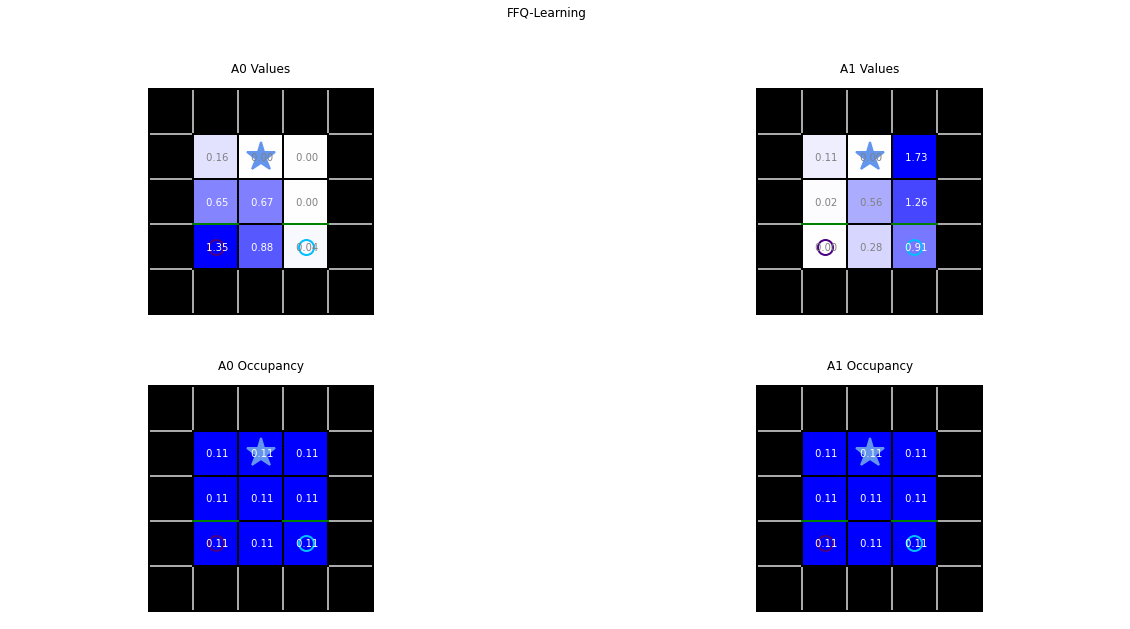

In [14]:
for k,alg in enumerate(algorithms): 
    fig,axes = plt.subplots(2,len(learning_agents),figsize=(20,10))
    fig.suptitle(alg.alg_name)
    for i,agent_name in enumerate(learning_agents):
        plotter = gg.plot(ax=axes[0][i])
        plotter.title(agent_name + " Values")
        q_matrix = results[k].pi.single_agent_policies[agent_name].q_matrix
        occupancy_matrix = results[k].pi.occupancy_matrix
        occupancy_matrix = np.zeros_like(occupancy_matrix)
        occupancy_matrix.fill(1.0/occupancy_matrix.shape[1])
        initial_state = gg.initial_state_dist().sample()
        initial_index = gg.state_list.index(initial_state)
#         plotter.plot_state_action_map(results[k].pi.positionActionMapping(agent_name,q_matrix,occupancy_matrix,initial_state))
        plotter.plot_state_map(results[k].pi.positionMapping(agent_name,q_matrix,occupancy_matrix,initial_state))
        plotter = gg.plot(ax=axes[1][i])
        plotter.title(agent_name + " Occupancy")
        plotter.plot_weights(results[k].pi.weightMapping(agent_name,occupancy_matrix,initial_state))

In [7]:
animations = []
for k,alg in enumerate(algorithms):
    fig, axes = plt.subplots(1,1,figsize=(20,10))
    fig.suptitle(alg.alg_name)
    trajectory = results[k].pi.run_on(gg,maxSteps=10)
    animator = gg.animate(figure=fig,ax=axes)
    animation = animator.animate_trajectory(trajectory)
    animations.append(animation)
display.display(*[display.HTML(animation.to_jshtml()) for animation in animations])
plt.close()

In [10]:
init_state = gg.initial_state_dist().sample()
random_action = {"A0":next(gg.joint_actions(init_state)["A0"]),"A1":next(gg.joint_actions(init_state)["A1"])}
joint_action = {"A0":{"x":1,"y":0},"A1":{"x":-1,"y":0}}
print(gg.next_state_dist(init_state,joint_action))
print(gg.next_state_dist(init_state,joint_action).probs)

DiscreteFactorTable{{'A0': {'name': 'A0', 'type': 'agent', 'x': 1, 'y': 1}, 'A1': {'name': 'A1', 'type': 'agent', 'x': 3, 'y': 1}}: -23.03, {'A0': {'name': 'A0', 'type': 'agent', 'x': 1, 'y': 1}, 'A1': {'name': 'A1', 'type': 'agent', 'x': 2, 'y': 1}}: -11.51, {'A0': {'name': 'A0', 'type': 'agent', 'x': 2, 'y': 1}, 'A1': {'name': 'A1', 'type': 'agent', 'x': 3, 'y': 1}}: -11.51}
(5.000025000124999e-06, 0.4999974999874998, 0.4999974999874998)


In [9]:
print(trajectory)

{'stateTraj': ({'A0': {'type': 'agent', 'name': 'A0', 'x': 1, 'y': 1}, 'A1': {'type': 'agent', 'name': 'A1', 'x': 3, 'y': 1}}, {'A0': {'name': 'A0', 'type': 'agent', 'x': 1, 'y': 1}, 'A1': {'name': 'A1', 'type': 'agent', 'x': 3, 'y': 2}}, {'A0': {'name': 'A0', 'type': 'agent', 'x': 2, 'y': 1}, 'A1': {'name': 'A1', 'type': 'agent', 'x': 3, 'y': 3}}, {'A0': {'name': 'A0', 'type': 'agent', 'x': 2, 'y': 2}, 'A1': {'name': 'A1', 'type': 'agent', 'x': 2, 'y': 3}}), 'actionTraj': ({'A0': {'x': 0, 'y': -1}, 'A1': {'x': 0, 'y': 1}}, {'A0': {'x': 1, 'y': 0}, 'A1': {'x': 0, 'y': 1}}, {'A0': {'x': 0, 'y': 1}, 'A1': {'x': -1, 'y': 0}}, {'A0': {'x': 0, 'y': -1}, 'A1': {'x': -1, 'y': 0}}), 'rewardTraj': ({'A0': 0, 'A1': 0}, {'A0': 0, 'A1': 0}, {'A0': 0, 'A1': 10}, {'A0': 0, 'A1': 0})}
